In [33]:
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
from pathlib import Path
import math
import random
import logging
import time
import pickle
import functools

from numba import jit

try:
    # import fail_here
    import cupy as cp
    import cupyx.scipy.ndimage
    xp = cp
    xndimage = cupyx.scipy.ndimage

    import numpy as np
    import scipy.ndimage

    use_cupy = True
except ModuleNotFoundError:
    import numpy as np
    import scipy.ndimage
    xp = np
    xndimage = scipy.ndimage

    use_cupy = False

In [34]:
use_cupy

True

In [35]:
xp

<module 'cupy' from 'C:\\Users\\ethan\\Fathom Radiant Dropbox\\Ethan Becker\\PC\\Documents\\Software\\fiber_modeling\\venv\\lib\\site-packages\\cupy\\__init__.py'>

In [36]:
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)
    mode_1, mode_2, mode_3 = data
    print('pickle loaded')

    if use_cupy:
        mode_1 = cp.array(mode_1)
        mode_2 = cp.array(mode_2)
        mode_3 = cp.array(mode_3)

pickle loaded


In [37]:
mode_1_power = .5
mode_2_power = 0.5
mode_2_phase = 0
mode_3_power = 0.5
mode_3_phase = math.pi / 3
rotate = 45
scale = 2
shift_x = 0
shift_y = 0
final_dimensions = (2000, 2000)

In [38]:
def polar_to_rect(r, phi):
    return r * (xp.cos(phi) + xp.sin(phi) * 1j)


def pad_and_combine(array_1, array_2):
    # array_1[:array_2.shape[0], :array_2.shape[1]] += array_2
    for i in range(array_2.shape[0]):
        for j in range(array_2.shape[1]):
            array_1[i, j] += array_2[i, j]
    return array_1

In [55]:
mode_1_complex = mode_1 * mode_1_power

mode_2_modulus = mode_2 * mode_2_power
# mode_2_angle = np.full_like(mode_2_modulus, mode_2_phase)
mode_2_complex = polar_to_rect(mode_2_modulus, mode_2_phase)

mode_3_modulus = mode_3 * mode_3_power
# mode_3_angle = np.full_like(mode_3_modulus, mode_3_phase)
mode_3_complex = polar_to_rect(mode_3_modulus, mode_3_phase)

total_complex = mode_1_complex + mode_2_complex + mode_3_complex
total_intensity = xp.square(xp.abs(total_complex))

total_rotate = xndimage.rotate(total_intensity, rotate, reshape=False, order=1)

total_rotate_zoom = xndimage.zoom(total_rotate, scale, order=1)
full_image = xp.zeros(final_dimensions)

full_image[:total_rotate_zoom.shape[0], :total_rotate_zoom.shape[1]] = total_rotate_zoom

full_image_shift = xndimage.shift(full_image, (shift_x, shift_y), mode='constant', cval=0, order=1)

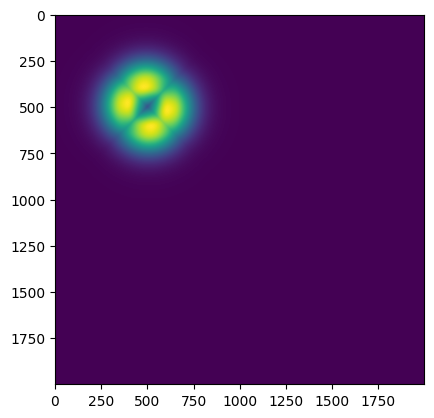

In [56]:
if use_cupy:
    plt.imshow(full_image_shift.get())
else:
    plt.imshow(full_image_shift)

0